In [34]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [35]:
df = pd.read_csv("./DF/train.csv")
df.shape

(1460, 81)

In [36]:
# How many null data do we have?

print ("Total null values: " ,df.isna().sum().sum())
df.columns

# Some columns doesn't have null values so let's see only the columns with any null value
columns_with_null_values = df[df.columns[df.isna().any()]].isna().sum()
print(columns_with_null_values)

Total null values:  6965
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


After examining some data I conclude that must of null values means that the property doesn't have the respective feature, for example, null values on Alley means that the house doesnt have a Alley access, so Ill add a value to denotate that the houses dont have the featured instead of have a null value.

I'll try to not remove rows since we dont have too much, and with more rows, the algorythm will be better trained.

In [37]:
# Null values for LotFrontage means that the houses have 0 feets since the street to the entrance, so the null values will be replaced with 0
df["LotFrontage"].fillna("None", inplace=True)

# Null values for Alley means that the houses dont have an alley entrance, so the null values will be replaced with None
df["Alley"].fillna("None", inplace=True)

# Null values for MasVnrType and MasVnrArea means that we dont know what kind of Masonry veneer type has the property or the area of it, since there are few null values here they will be replaced with None
df["MasVnrType"].fillna("None", inplace=True)
df["MasVnrArea"].fillna("None", inplace=True)

# FireplaceQu will be filled with None since it's asociate to the reason that there isnt fireplaces.
df["FireplaceQu"].fillna("None", inplace=True)

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, and BsmtFinType2 are related and im not sure how to treat it now, so i'll leave it as is
basement_columns=["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
df.loc[:, basement_columns] = df.loc[:, basement_columns].fillna("None")

# Since Electrical has only one null value I'll remove it (there are other fields of this row with null values)
null_index = df[df["Electrical"].isnull()].index
df.drop(null_index, axis=0, inplace=True)

# GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond null values will be filled with None indicating that the hose doesnt have garage, it based on GarageCars and GarageArea that are 0 for those rows.
garage_columns = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond"]
df.loc[:, garage_columns] = df.loc[:, garage_columns].fillna("None")

# PoolQC, Fence and MiscFeature will be filled with None, indicating that there isnt pool, fence or anothe miscelaneous furniture, this desition is taking in account that other fields as the pool area that indicates the missing of it.
other_columns = ["PoolQC", "Fence" ,"MiscFeature"]
df.loc[:, other_columns] = df.loc[:, other_columns].fillna("None")


In [38]:
object_columns = df.select_dtypes(include=["object"])
df[object_columns.columns] = df[object_columns.columns].astype("category")
df.dtypes

Id                  int64
MSSubClass          int64
MSZoning         category
LotFrontage      category
LotArea             int64
                   ...   
MoSold              int64
YrSold              int64
SaleType         category
SaleCondition    category
SalePrice           int64
Length: 81, dtype: object

In [39]:
df.columns[-1]

'SalePrice'

## Working With Numerical Data
Since there are too much columns I'll start evaluating only numerical data


In [40]:
numerical_df = df.select_dtypes(exclude="category")
numerical_df.shape

(1459, 35)

### Reference prediction algorythms
Using prediction algorythms to have as reference and see if the featured engineering that will be realized after is going good.

In [41]:
# Splitting data
X = numerical_df.drop("SalePrice", axis=1)
y = numerical_df.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [42]:
# Applying A random Forest Clasiffier as reference

clf = RandomForestClassifier(n_estimators=100)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.00684931506849315


<AxesSubplot:>

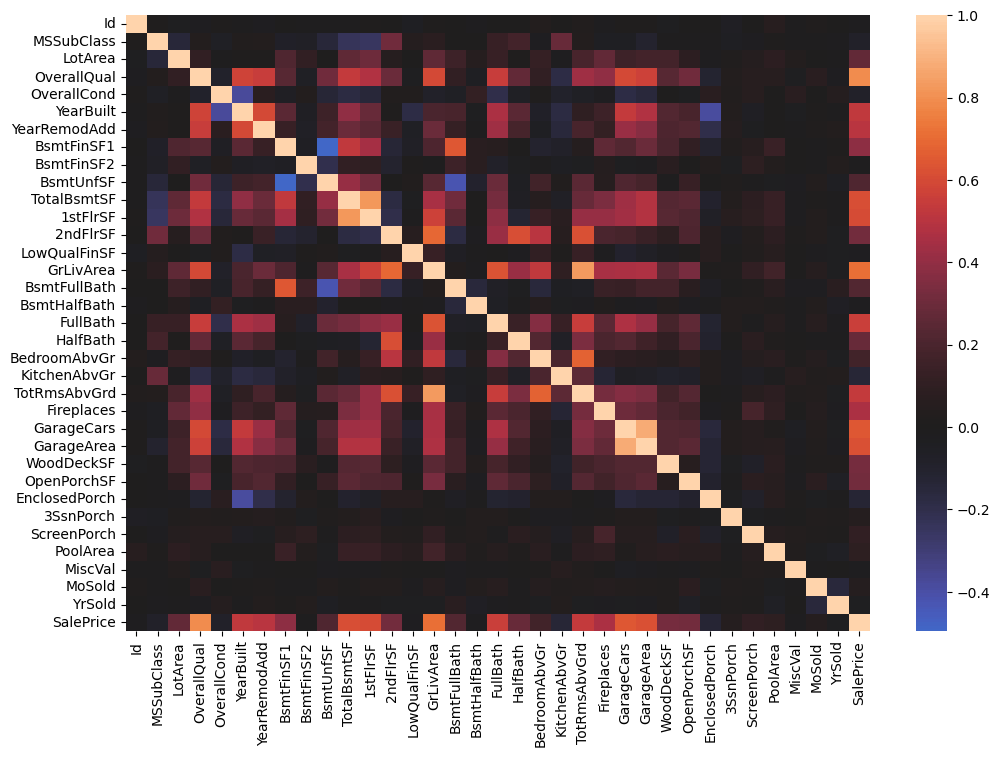

In [43]:
# Printing a correlation matrix
corr = numerical_df.corr()

plt.figure(figsize=(12, 8))

sns.heatmap(
    data=corr,
    center=0
)

<AxesSubplot:>

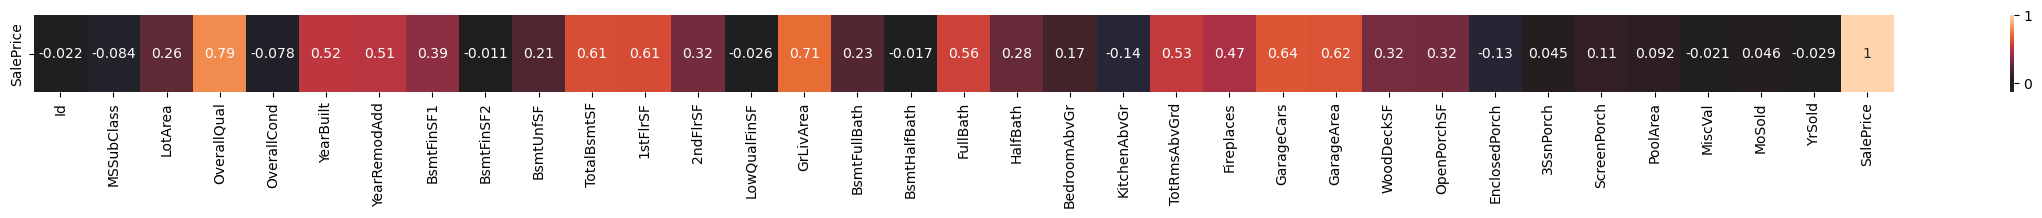

In [44]:
# Looking for what variables have more correlation with the variable "SalePrice"
corr_row = corr.loc[["SalePrice"]]

plt.figure(figsize=(30, 1))
sns.heatmap(
    data = corr_row,
    center = 0,
    annot = True
)

We will discard the vaiables with a correlation near to 0

In [45]:
unrelevant_columns = corr_row[(corr_row < 0.25) & (corr_row > -0.25)].T
unrelevant_columns = unrelevant_columns.dropna().index

In [46]:
numerical_2 = numerical_df.drop(unrelevant_columns, axis= 1)

<AxesSubplot:>

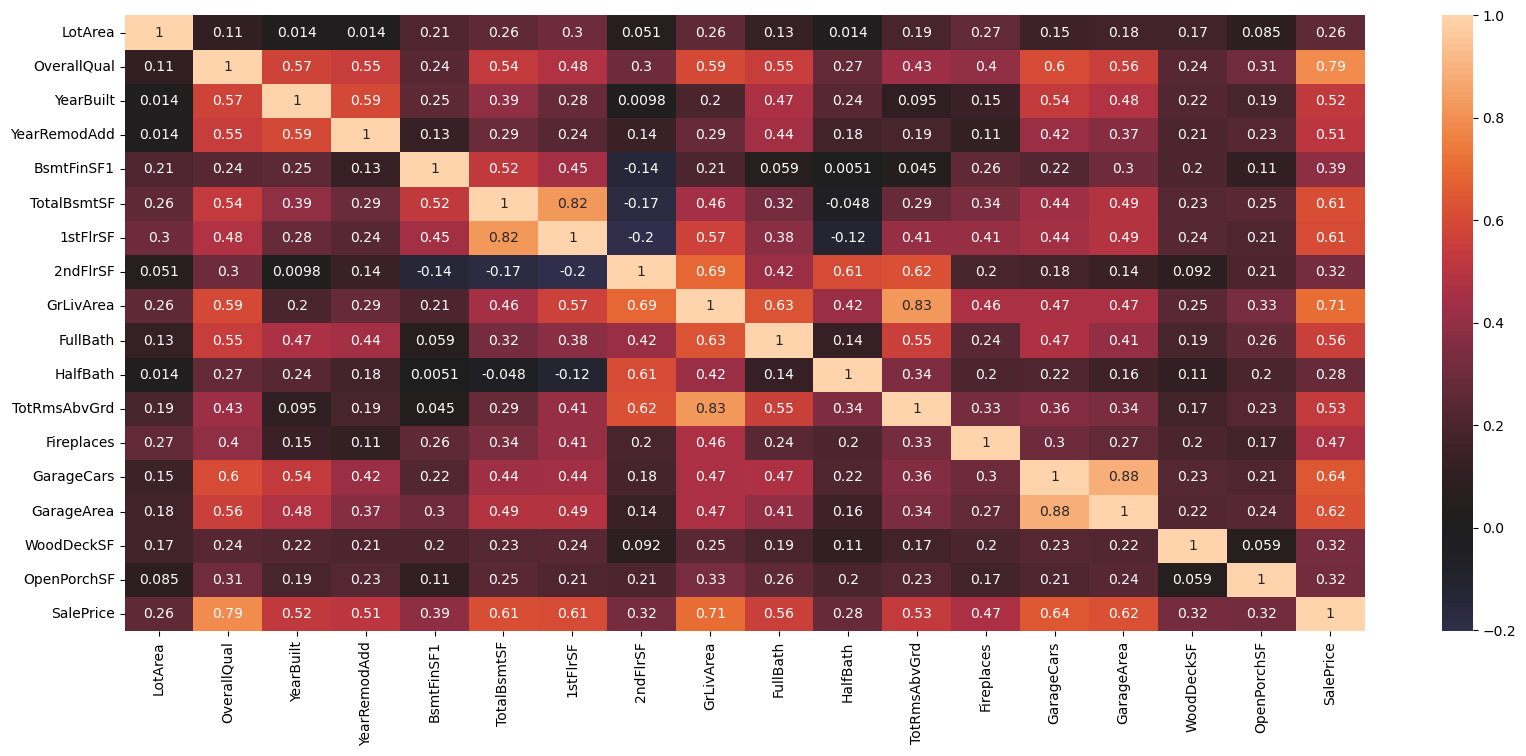

In [47]:
corr2 = numerical_2.corr()

plt.figure(figsize=(20, 8))

sns.heatmap(
    data=corr2,
    center=0,
    annot = True
)

In [48]:
# Removing variables with a high correlation between themselves to avoid overfitting

# Removing 1stFlrSF since it's the area of the first floor and the TotalBsmtSF is the total basement area, and in most cases the first floor is the same basement.
numerical_2.drop("1stFlrSF", axis=1 ,inplace=True)

# Removing TotRmsAbvGrd, it's too correlated with GrLivArea
numerical_2.drop("TotRmsAbvGrd", axis=1, inplace=True)

# Removing GarageArea since it's high correlated with GarageCars and GarageCars has a higher correlation with the target variable (SalePrice)
numerical_2.drop("GarageArea", axis=1, inplace=True)

In [49]:
# Splitting data
X = numerical_2.drop("SalePrice", axis=1)
y = numerical_2.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.0


## Working With Categorical Data
Since there are too much columns I'll continue evaluating and manipulating only categorical data

In [50]:
cat = df.select_dtypes(include="category")
print(cat.shape)

cat_columns = list(cat.columns)

(1459, 46)


In [51]:
# initialize the encoder
encoder = CatBoostEncoder(cols=cat_columns)

# fit the encoder on the dataset
encoder.fit(df[cat_columns], df['SalePrice'])

# transform the dataset
encoded_df = pd.DataFrame(encoder.transform(df[cat_columns]))

# Adding the SalesPrice column to the df to make a correlation matrix
encoded_df["SalePrice"] = df["SalePrice"]

print(encoded_df)

           MSZoning    LotFrontage         Street          Alley  \
0     191016.663245  177141.408773  181139.775375  183461.941852   
1     191016.663245  180475.177068  181139.775375  183461.941852   
2     191016.663245  177550.819740  181139.775375  183461.941852   
3     191016.663245  128801.190242  181139.775375  183461.941852   
4     191016.663245  223540.539479  181139.775375  183461.941852   
...             ...            ...            ...            ...   
1455  191016.663245  190493.039479  181139.775375  183461.941852   
1456  191016.663245  215095.716946  181139.775375  183461.941852   
1457  191016.663245  183717.462174  181139.775375  183461.941852   
1458  191016.663245  177550.819740  181139.775375  183461.941852   
1459  191016.663245  191893.970274  181139.775375  183461.941852   

           LotShape    LandContour      Utilities      LotConfig  \
0     164769.337724  180193.991148  180960.162025  176950.814063   
1     164769.337724  180193.991148  180960.1620

<AxesSubplot:>

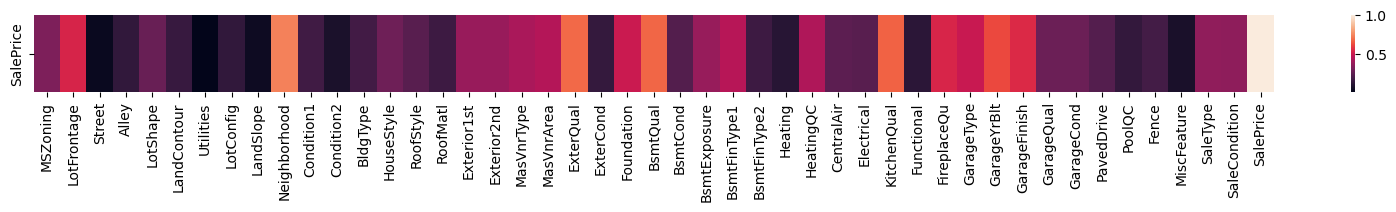

In [52]:
# Creating a Correlation matrix with the categorical variables
cat_corr = encoded_df.corr()
cat_corr_row = cat_corr.loc[["SalePrice"]]

plt.figure(figsize=(20,1))

sns.heatmap(
    data= cat_corr_row
)

<AxesSubplot:>

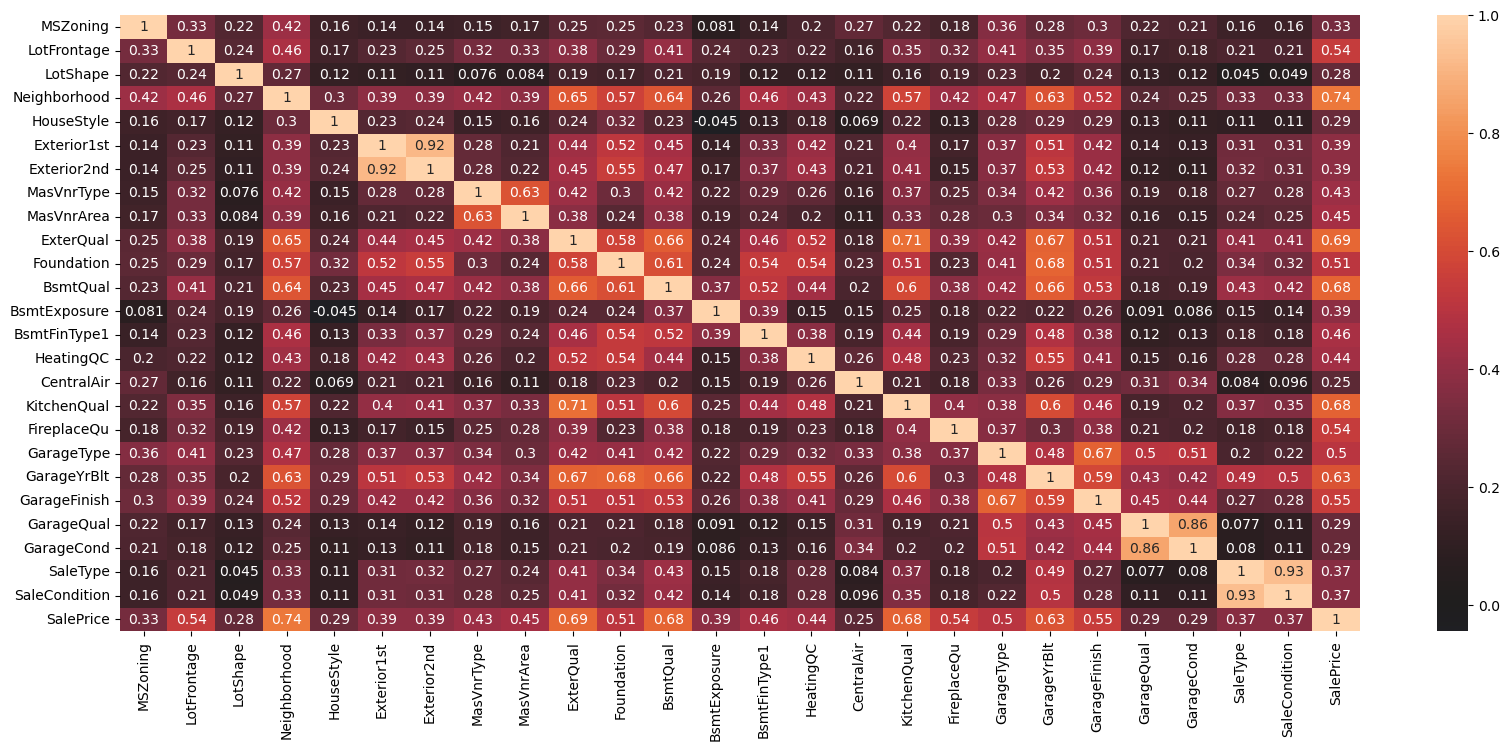

In [53]:
# Removing data that has no correlation
unrelevant_columns = cat_corr_row[(cat_corr_row < 0.25) & (cat_corr_row > -0.25)].T
unrelevant_columns = unrelevant_columns.dropna().index

# Creating a new DF with the most relevant data
cat_2 = encoded_df.drop(unrelevant_columns, axis= 1)

# Printing the ew corr matrix
cat_corr_2 = cat_2.corr()

plt.figure(figsize=(20,8))

sns.heatmap(
    data= cat_corr_2,
    center = 0,
    annot = True
)

In [54]:
# Removing High correlated data
cat_2.drop(["GarageQual", "SaleType", "SalePrice"], axis=1, inplace=True)

## Joining Dataframes
Joininng the numerical and categorical data

In [61]:
df2 = pd.concat([numerical_2, cat_2], axis=1, join="inner")
df2.shape

(1459, 38)

In [69]:
from sklearn.linear_model import LogisticRegression

# Splitting data
X = df2.drop("SalePrice", axis=1)
y = df2.SalePrice

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

/home/alphalejo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
